In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from time import time
from alibi.datasets import fetch_adult
from alibi.explainers import CounterfactualProto
from alibi.utils import ohe_to_ord, ord_to_ohe

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

2023-01-19 16:41:59.446059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:41:59.575121: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-19 16:41:59.580649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7h

TF version:  2.10.1
Eager execution enabled:  False


In [2]:
adult = fetch_adult()
data = adult.data
target = adult.target
feature_names = adult.feature_names
category_map_tmp = adult.category_map
target_names = adult.target_names

In [3]:
def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

In [4]:
set_seed()
data_perm = np.random.permutation(np.c_[data, target])
X = data_perm[:,:-1]
y = data_perm[:,-1]

In [5]:

idx = 30000
y_train, y_test = y[:idx], y[idx+1:]

In [6]:
X = np.c_[X[:, 1:8], X[:, 11], X[:, 0], X[:, 8:11]]

In [7]:
feature_names = feature_names[1:8] + feature_names[11:12] + feature_names[0:1] + feature_names[8:11]
print(feature_names)

['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Age', 'Capital Gain', 'Capital Loss', 'Hours per week']


In [8]:

category_map = {}
for i, (_, v) in enumerate(category_map_tmp.items()):
    category_map[i] = v

In [9]:
cat_vars_ord = {}
n_categories = len(list(category_map.keys()))
for i in range(n_categories):
    cat_vars_ord[i] = len(np.unique(X[:, i]))
print(cat_vars_ord)

{0: 9, 1: 7, 2: 4, 3: 9, 4: 6, 5: 5, 6: 2, 7: 11}


In [10]:
cat_vars_ohe = ord_to_ohe(X, cat_vars_ord)[1]
print(cat_vars_ohe)

{0: 9, 9: 7, 16: 4, 20: 9, 29: 6, 35: 5, 40: 2, 42: 11}


In [11]:
X_num = X[:, -4:].astype(np.float32, copy=False)
xmin, xmax = X_num.min(axis=0), X_num.max(axis=0)
rng = (-1., 1.)
X_num_scaled = (X_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]

In [12]:
X_cat = X[:, :-4].copy()
ohe = OneHotEncoder(categories='auto', sparse=False).fit(X_cat)
X_cat_ohe = ohe.transform(X_cat)

In [13]:
X = np.c_[X_cat_ohe, X_num_scaled].astype(np.float32, copy=False)
X_train, X_test = X[:idx, :], X[idx+1:, :]
print(X_train.shape, X_test.shape)

(30000, 57) (2560, 57)


In [14]:
def nn_ohe():
    
    x_in = Input(shape=(57,))
    x = Dense(60, activation='relu')(x_in)
    x = Dropout(.2)(x)
    x = Dense(60, activation='relu')(x)
    x = Dropout(.2)(x)
    x = Dense(60, activation='relu')(x)
    x = Dropout(.2)(x)
    x_out = Dense(2, activation='softmax')(x)
    
    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return nn

In [15]:
set_seed()
nn = nn_ohe()
nn.summary()
nn.fit(X_train, to_categorical(y_train), batch_size=256, epochs=30, verbose=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense (Dense)               (None, 60)                3480      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0     

2023-01-19 16:42:07.882988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:42:07.902057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [16]:

X = X_test[0].reshape((1,) + X_test[0].shape)

In [17]:
shape = X.shape
beta = .01
c_init = 1.
c_steps = 5
max_iterations = 500
rng = (-1., 1.)  # scale features between -1 and 1
rng_shape = (1,) + data.shape[1:]
feature_range = ((np.ones(rng_shape) * rng[0]).astype(np.float32), 
                 (np.ones(rng_shape) * rng[1]).astype(np.float32))

In [18]:

def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

In [19]:
set_seed()
cf = CounterfactualProto(nn,
                         shape,
                         beta=beta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,  # OHE flag
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [20]:
cf.fit(X_train, d_type='abdm', disc_perc=[25, 50, 75]);

In [21]:
def plot_bar(dist, cols, figsize=(10,4)):
    dist = dist.reshape(dist.shape[0])
    idx = np.argsort(dist)
    fig, ax = plt.subplots(figsize=figsize)
    plt.bar(cols[idx], dist[idx])
    print(cols[idx])

['Dropout' 'High School grad' 'Associates' 'Bachelors' 'Masters'
 'Prof-School' 'Doctorate']


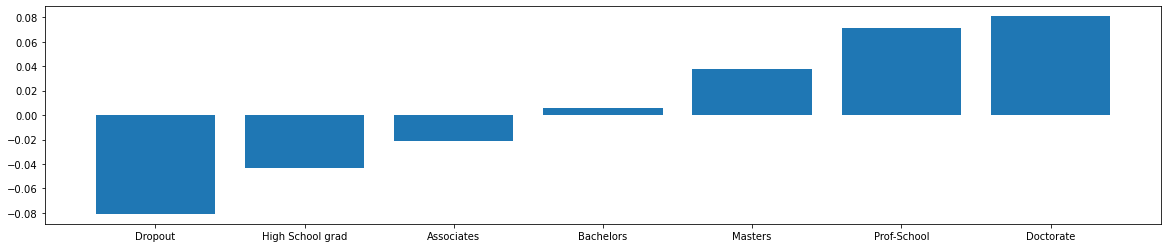

In [22]:
cat = 'Education'
idx = feature_names.index(cat)
plot_bar(cf.d_abs[idx], np.array(category_map[idx]), figsize=(20,4))

In [23]:
explanation = cf.explain(X)

In [24]:
def describe_instance(X, explanation, eps=1e-2):
    print('Original instance: {}  -- proba: {}'.format(target_names[explanation.orig_class],
                                                       explanation.orig_proba[0]))
    print('Counterfactual instance: {}  -- proba: {}'.format(target_names[explanation.cf['class']],
                                                             explanation.cf['proba'][0]))
    print('\nCounterfactual perturbations...')
    print('\nCategorical:')
    X_orig_ord = ohe_to_ord(X, cat_vars_ohe)[0]
    X_cf_ord = ohe_to_ord(explanation.cf['X'], cat_vars_ohe)[0]
    delta_cat = {}
    for i, (_, v) in enumerate(category_map.items()):
        cat_orig = v[int(X_orig_ord[0, i])]
        cat_cf = v[int(X_cf_ord[0, i])]
        if cat_orig != cat_cf:
            delta_cat[feature_names[i]] = [cat_orig, cat_cf]
    if delta_cat:
        for k, v in delta_cat.items():
            print('{}: {}  -->   {}'.format(k, v[0], v[1]))
    print('\nNumerical:')
    delta_num = X_cf_ord[0, -4:] - X_orig_ord[0, -4:]
    n_keys = len(list(cat_vars_ord.keys()))
    for i in range(delta_num.shape[0]):
        if np.abs(delta_num[i]) > eps:
            print('{}: {:.2f}  -->   {:.2f}'.format(feature_names[i+n_keys],
                                            X_orig_ord[0,i+n_keys],
                                            X_cf_ord[0,i+n_keys]))

In [25]:
describe_instance(X, explanation)

Original instance: <=50K  -- proba: [0.7531671  0.24683289]
Counterfactual instance: >50K  -- proba: [0.4991845 0.5008155]

Counterfactual perturbations...

Categorical:
Country: United-States  -->   Euro_1

Numerical:


In [26]:
set_seed()
cf.fit(X_train, d_type='mvdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

Original instance: <=50K  -- proba: [0.7531671  0.24683289]
Counterfactual instance: >50K  -- proba: [0.4156456  0.58435434]

Counterfactual perturbations...

Categorical:
Education: Associates  -->   Bachelors

Numerical:
Capital Gain: -1.00  -->   -0.98


In [27]:
use_kdtree = True
theta = 10.  # weight of prototype loss term

In [28]:
set_seed()
X = X_test[7].reshape((1,) + X_test[0].shape)
cf = CounterfactualProto(nn,
                         shape,
                         beta=beta,
                         theta=theta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         use_kdtree=use_kdtree,
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )
cf.fit(X_train, d_type='abdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

No encoder specified. Using k-d trees to represent class prototypes.


Original instance: <=50K  -- proba: [0.536046   0.46395397]
Counterfactual instance: >50K  -- proba: [0.44951326 0.5504867 ]

Counterfactual perturbations...

Categorical:
Education: Bachelors  -->   Prof-School

Numerical:


In [29]:
def ae_model():
    # encoder
    x_in = Input(shape=(57,))
    x = Dense(60, activation='relu')(x_in)
    x = Dense(30, activation='relu')(x)
    x = Dense(15, activation='relu')(x)
    encoded = Dense(10, activation=None)(x)
    encoder = Model(x_in, encoded)
    
    # decoder
    dec_in = Input(shape=(10,))
    x = Dense(15, activation='relu')(dec_in)
    x = Dense(30, activation='relu')(x)
    x = Dense(60, activation='relu')(x)
    decoded = Dense(57, activation=None)(x)
    decoder = Model(dec_in, decoded)
    
    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder, decoder

In [30]:
set_seed()
ae, enc, dec = ae_model()
ae.summary()
ae.fit(X_train, X_train, batch_size=128, epochs=100, validation_data=(X_test, X_test), verbose=0)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 57)]              0         
                                                                 
 model_1 (Functional)        (None, 10)                5935      
                                                                 
 model_2 (Functional)        (None, 57)                5982      
                                                                 
Total params: 11,917
Trainable params: 11,917
Non-trainable params: 0
_________________________________________________________________


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [31]:
beta = .1  # L1
gamma = 10.  # autoencoder
theta = .1  # prototype

In [32]:
set_seed()
X = X_test[19].reshape((1,) + X_test[0].shape)
cf = CounterfactualProto(nn,
                         shape,
                         beta=beta,
                         enc_model=enc,
                         ae_model=ae,
                         gamma=gamma,
                         theta=theta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )
cf.fit(X_train, d_type='abdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Original instance: <=50K  -- proba: [0.5141088  0.48589122]
Counterfactual instance: >50K  -- proba: [0.42992243 0.57007766]

Counterfactual perturbations...

Categorical:
Education: High School grad  -->   Associates

Numerical:


In [33]:
use_kdtree = True
theta = 10.  # weight of prototype loss term

In [34]:
set_seed()

X = X_test[24].reshape((1,) + X_test[0].shape)

# define predict function
predict_fn = lambda x: nn.predict(x)

cf = CounterfactualProto(predict_fn,
                         shape,
                         beta=beta,
                         theta=theta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         use_kdtree=use_kdtree,
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )
cf.fit(X_train, d_type='abdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

No encoder specified. Using k-d trees to represent class prototypes.


Original instance: >50K  -- proba: [0.23264737 0.7673526 ]
Counterfactual instance: <=50K  -- proba: [0.50304615 0.49695385]

Counterfactual perturbations...

Categorical:

Numerical:
Age: -0.15  -->   -0.17
Hours per week: -0.20  -->   -0.50
